
# Slim simulations



Load global analysis variables:

In [1]:
%run standard.py

In [2]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy as np
import pandas as pd
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window
import genominterv

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%%html
<style> table { font-variant-numeric: tabular-nums; } </style>

Import variables global to the entire analysis:

In [4]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [5]:
if str(ag.scripts_dir) not in sys.path:
    sys.path.append(str(ag.scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

Plotting setup:

In [6]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("ticks")
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

def abline(slope, intercept, ax=None):
    "Add a straight line through the plot"
    if ax is None:
        ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color='grey')

In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/e

Ignore warnings:

In [7]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Load meta data

Easy loading of meta data in a consistent manner across code

In [8]:
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=ag.meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Sanity checks on autosomal simulations

### Mean pairwise differences

In [9]:
dir_path = ag.root_dir / 'steps/slim/simulations/standard/100/11300/A/nosweep/0/0/'
means = list()
for path in dir_path.iterdir():
#     if path.name.endswith('0_0_0.hdf'):
    if re.search(r'\d+.hdf$', path.name):
        df = pd.read_hdf(path)
        means.append(df.dist.mean())
np.mean(means)

KeyboardInterrupt: 

This should match `autosome_pi` in the previous notebook.

### SFS

Compute SFS for chromosome 7:

In [37]:
freq_data_obs = pd.read_csv(ag.root_dir / 'steps/smcpp/vcf/nonafr_analyzed_individuals_chr7_with_aa.frq', sep='\t',
                        skiprows=1, names=['chrom','pos', 'n_alleles', 'n_chr', 'anc_freq', 'der_freq'])
freq_data_obs.head()
# histogram of frequencies with specified bins

,chrom,pos,n_alleles,n_chr,anc_freq,der_freq
0,7,118084,2,280,0.778571,0.221429
1,7,118114,2,280,0.307143,0.692857
2,7,118184,2,280,0.996429,0.003571
3,7,118232,2,280,0.732143,0.267857
4,7,118268,2,280,0.989286,0.010714


In [38]:
freq_data_obs.der_freq.min(), freq_data_obs.der_freq.max() # strange...
# maybe it is because I did not recode or soemthing to remove monomorphic sites after subsetting the VCF...

(0.0, 1.0)

Compute SFS for simulations:

In [39]:
# use pathlib to glob all freq files
path = Path(ag.root_dir / 'steps/slim/simulations/standard/100/11300/A/nosweep')
df_list = []
for path in path.glob('**/standard*A_nosweep*.frq'):
    df = pd.read_csv(path, sep='\t', header=0, names=['chrom', 'pos', 'n_alleles', 'n_chr', 'anc_freq', 'der_freq'])
    df_list.append(df)

freq_data_sim = pd.concat(df_list)
freq_data_sim.head()

# for each file: read it in, concat result to list of dfs
# concat all dfs

# histogram of frequencies with specified bins

,chrom,pos,n_alleles,n_chr,anc_freq,der_freq
0,1,1131,2,140,0.707143,0.292857
1,1,1245,2,140,0.992857,0.007143
2,1,1492,2,140,0.107143,0.892857
3,1,1498,2,140,0.964286,0.035714
4,1,1598,2,140,0.992857,0.007143


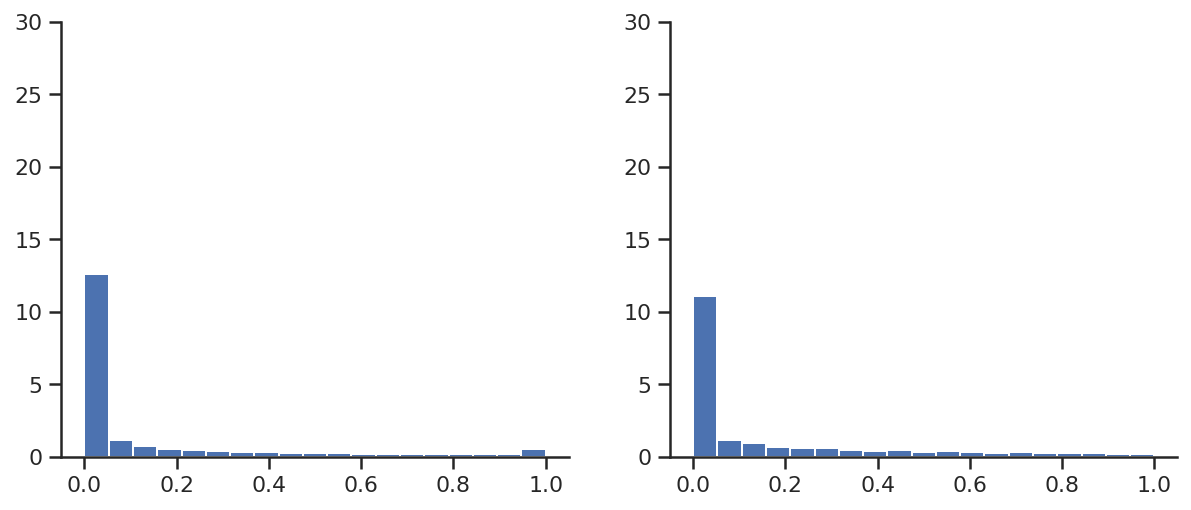

In [45]:
nbins = 20
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(freq_data_obs.loc[(freq_data_obs.der_freq > 0) & (freq_data_obs.der_freq < 1)].der_freq, 
         bins=np.linspace(0, 1, nbins), density=True)
axes[1].hist(freq_data_sim.loc[(freq_data_sim.der_freq > 0) & (freq_data_sim.der_freq < 1)].der_freq, 
         bins=np.linspace(0, 1, nbins), density=True)
axes[0].set_ylim(top=30)
axes[1].set_ylim(top=30)
sns.despine()

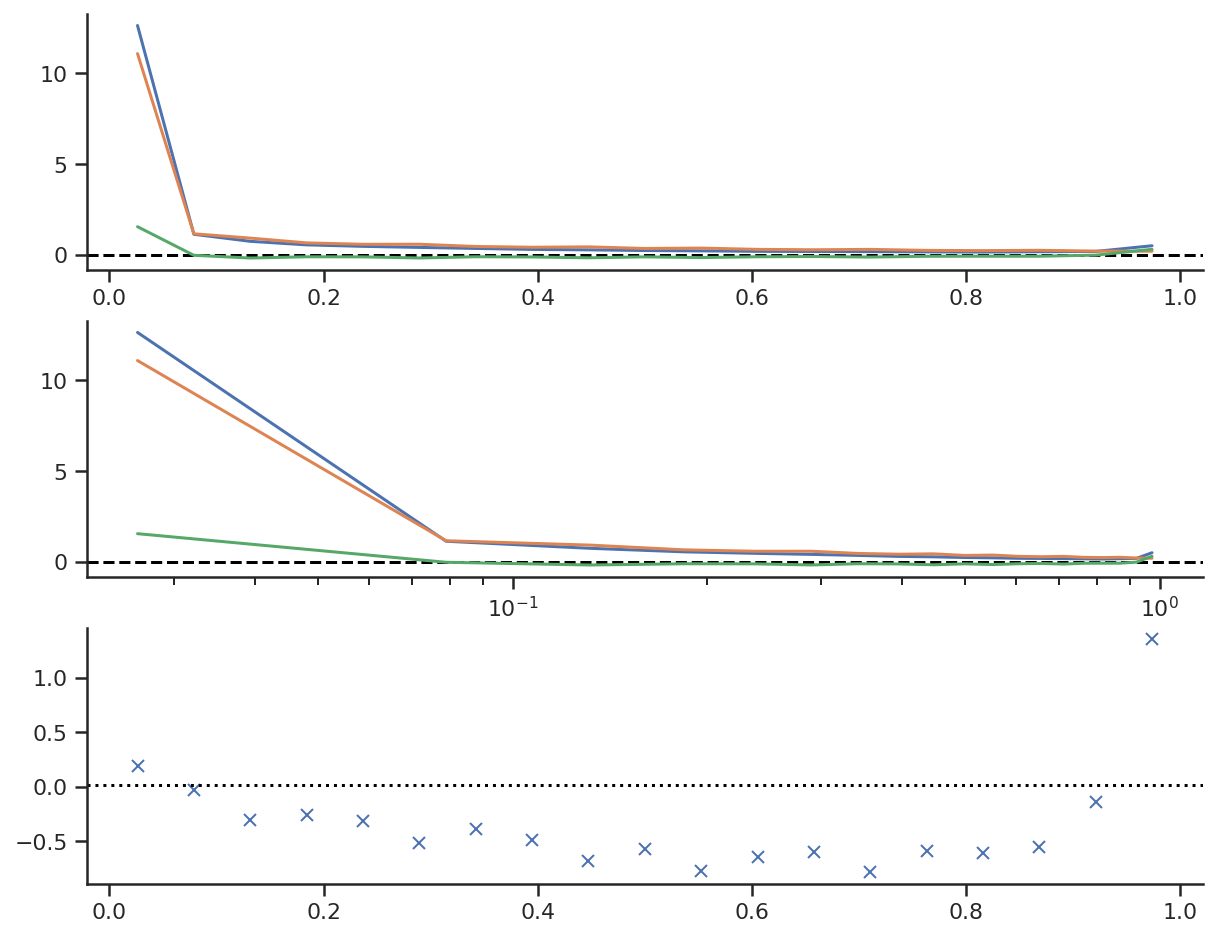

In [46]:
freq_data_sim_hist = np.histogram(freq_data_sim.loc[(freq_data_sim.der_freq > 0) & (freq_data_sim.der_freq < 1)].der_freq,
             bins=np.linspace(0, 1, nbins), density=True)
freq_data_obs_hist = np.histogram(freq_data_obs.loc[(freq_data_obs.der_freq > 0) & (freq_data_obs.der_freq < 1)].der_freq, 
             bins=np.linspace(0, 1, nbins), density=True)

fig, axes = plt.subplots(3, 1, figsize=(10, 8))
x = freq_data_obs_hist[1][:-1] + (freq_data_obs_hist[1][1:] - freq_data_obs_hist[1][:-1])/2

axes[0].axhline(0, color='black', linestyle='dashed')
axes[0].plot(x, freq_data_obs_hist[0])
axes[0].plot(x, freq_data_sim_hist[0])
axes[0].plot(x, freq_data_obs_hist[0] - freq_data_sim_hist[0])

axes[1].axhline(0, color='black', linestyle='dashed')
axes[1].plot(x, freq_data_obs_hist[0])
axes[1].plot(x, freq_data_sim_hist[0])
axes[1].plot(x, freq_data_obs_hist[0] - freq_data_sim_hist[0])
axes[1].set_xscale('log')

axes[2].plot(x, np.log2(freq_data_obs_hist[0] / freq_data_sim_hist[0]), 'x')
axes[2].axhline(0.01, color='black', linestyle='dotted')

sns.despine()

### LD decay

Compute LD decay for chromosome 7:

In [12]:
import dask.dataframe as dd

In [10]:
from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=4, processes=True, memory_limit='16GB')
client

Client Scheduler: tcp://127.0.0.1:43172 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 16.00 GB


In [48]:
# ssh -L8787:s05n16.genomedk.net:8787 kmt@login.genome.au.dk

In [49]:
#client.shutdown()
# client.close()
# client.restart()

In [50]:
ld_data_obs = dd.read_csv(ag.root_dir / 'steps/smcpp/vcf/nonafr_analyzed_individuals_chr7_with_aa.geno.ld',
                 sep='\t', header=0, names=['chrom', 'pos1', 'pos2', 'n_indiv', 'r2'])

ld_data_obs['dist'] = (ld_data_obs.pos1 - ld_data_obs.pos2).abs().round(-3)

In [51]:
ld_data_obs_means = ld_data_obs.groupby('dist').r2.mean().compute().reset_index().sort_values(by='dist')
ld_data_obs_means.head()

,dist,r2
0,0,0.263952
1,1000,0.252805
2,2000,0.241179
3,3000,0.230312
4,4000,0.220760


In [24]:
ld_data_obs_eur = dd.read_csv(ag.root_dir / 'steps/smcpp/vcf/nonafr_analyzed_europeans_chr7_with_aa.geno.ld',
                 sep='\t', header=0, names=['chrom', 'pos1', 'pos2', 'n_indiv', 'r2'])

ld_data_obs_eur['dist'] = (ld_data_obs_eur.pos1 - ld_data_obs_eur.pos2).abs().round(-3)

ld_data_obs_eur_means = ld_data_obs_eur.groupby('dist').r2.mean().compute().reset_index().sort_values(by='dist')
ld_data_obs_eur_means.head()

,dist,r2
0,0,0.329777
1,1000,0.327516
2,2000,0.313698
3,3000,0.301369
4,4000,0.290355


In [25]:
ld_data_obs_papuans = dd.read_csv(ag.root_dir / 'steps/smcpp/vcf/nonafr_analyzed_papuans_chr7_with_aa.geno.ld',
                 sep='\t', header=0, names=['chrom', 'pos1', 'pos2', 'n_indiv', 'r2'])

ld_data_obs_papuans['dist'] = (ld_data_obs_papuans.pos1 - ld_data_obs_papuans.pos2).abs().round(-3)

ld_data_obs_papuans_means = ld_data_obs_papuans.groupby('dist').r2.mean().compute().reset_index().sort_values(by='dist')
ld_data_obs_papuans_means.head()

,dist,r2
0,0,0.419400
1,1000,0.433335
2,2000,0.421635
3,3000,0.409062
4,4000,0.397075


In [26]:
#client.shutdown()

Compute LD decay for simulations:

In [15]:
glob = str(ag.root_dir) + \
    '/steps/slim/simulations/standard/100/11300/A/nosweep/*/*/standard_100_11300_A_nosweep*.hap.ld'
ld_data_sim = dd.read_csv(glob, sep='\t', header=0, names=['chrom', 'pos1', 'pos2', 'n_chrom', 'r2', 'D', 'Dprime'])
ld_data_sim['dist'] = (ld_data_sim.pos1 - ld_data_sim.pos2).abs().round(-3)
ld_data_sim.head()

,chrom,pos1,pos2,n_chrom,r2,D,Dprime,dist
0,1,26,6328,140,0.011191,0.006224,1.0,6000
1,1,26,6606,140,0.011858,0.006429,1.0,7000
2,1,26,8910,140,0.011191,0.006224,1.0,9000
3,1,26,9419,140,0.011191,0.006224,1.0,9000
4,1,26,11034,140,0.154589,0.013061,1.0,11000


In [27]:
ld_data_sim_means = ld_data_sim.groupby('dist').r2.mean().compute().reset_index().sort_values(by='dist')

In [28]:
ld_data_sim_means.head()

,dist,r2
0,0,0.368283
1,1000,0.291747
2,2000,0.235641
3,3000,0.201981
4,4000,0.178394


In [16]:
glob = str(ag.root_dir) + \
    '/steps/slim/simulations/standard/100/11300/A/nosweep/*/*/standard_100_11300_A_nosweep*.geno.ld'
ld_geno_data_sim = dd.read_csv(glob, sep='\t', header=0, names=['chrom', 'pos1', 'pos2', 'n_indiv', 'r2'])
ld_geno_data_sim['dist'] = (ld_geno_data_sim.pos1 - ld_geno_data_sim.pos2).abs().round(-3)

ld_geno_data_sim_means = ld_geno_data_sim.groupby('dist').r2.mean().compute().reset_index().sort_values(by='dist')

In [17]:
ld_geno_data_sim_means.head()

,dist,r2
0,0,0.310287
1,1000,0.246588
2,2000,0.199653
3,3000,0.173232
4,4000,0.153783


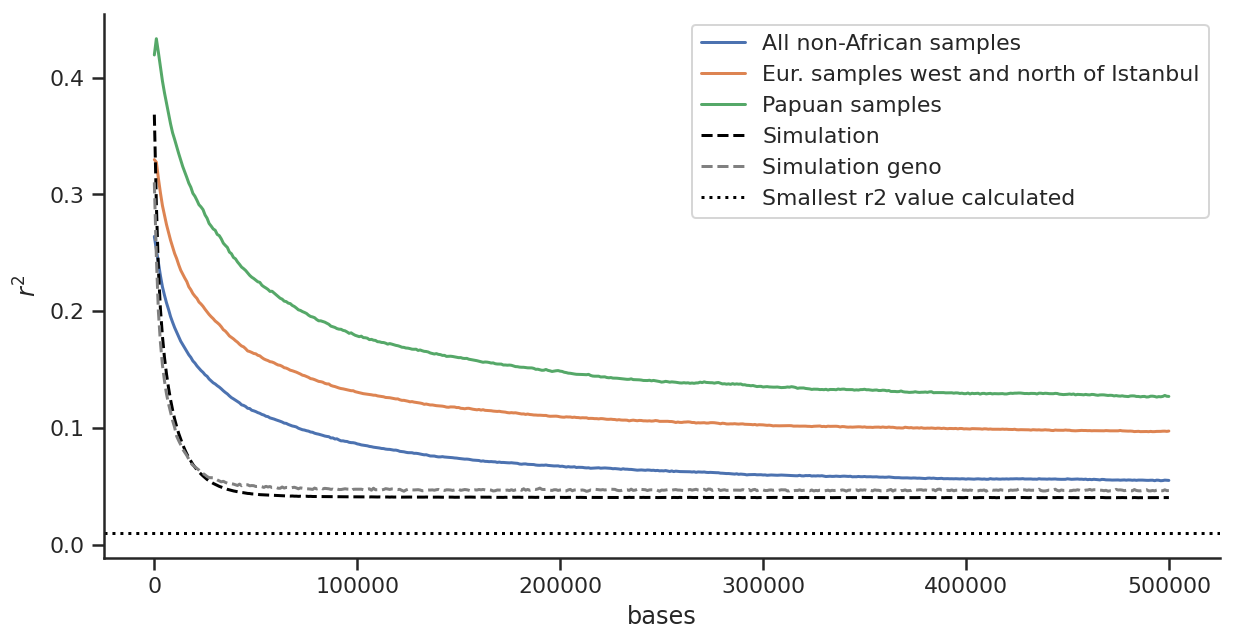

In [21]:
plt.figure(figsize=(10,5))
plt.plot(ld_data_obs_means.dist, ld_data_obs_means.r2, '-', label='All non-African samples')
plt.plot(ld_data_obs_eur_means.dist, ld_data_obs_eur_means.r2, '-', label='Eur. samples west and north of Istanbul')
plt.plot(ld_data_obs_papuans_means.dist, ld_data_obs_papuans_means.r2, '-', label='Papuan samples')
plt.plot(ld_data_sim_means.dist, ld_data_sim_means.r2, '--',color='black', label='Simulation')
plt.plot(ld_geno_data_sim_means.dist, ld_geno_data_sim_means.r2, '--',color='grey', label='Simulation geno')
plt.ylabel('$r^2$')
plt.xlabel('bases')
#plt.xscale('log')
plt.axhline(0.01, color='black', linestyle='dotted', label='Smallest r2 value calculated')
#plt.xlim(0, 10000)
plt.legend()
sns.despine()

### What to do?

The lower LD propably results from simulated panmixia rather than non-African population structure.

In the observed data, structure will tend to maintain LD within populations that is then only disrupted when we come close to the bottleneck.

1. Read [Gutenkunst paper](https://academic.oup.com/g3journal/article/7/11/3605/6027516) about inference
2. Make an experiment where you know what the LD decay: Try to simulate a few with Terhorst 1000 genomes CEU deomography and compute LD again.
3. 




Maybe use the Terhorst CEU but with out rescaling to fit pi
Then simulate with slim
Then raise mutation rate in slim to fit observed pi

In [31]:
ld_data_obs_means.to_hdf(ag.results_dir / 'ld_data_obs_means.hdf', 'df', format='table', mode='w')
ld_data_obs_eur_means.to_hdf(ag.results_dir / 'ld_data_obs_eur_means.hdf', 'df', format='table', mode='w')
ld_data_obs_papuans_means.to_hdf(ag.results_dir / 'ld_data_obs_papuans_means.hdf', 'df', format='table', mode='w')
ld_data_sim_means.to_hdf(ag.results_dir / 'ld_data_sim_means.hdf', 'df', format='table', mode='w')
ld_data_geno_sim_means.to_hdf(ag.results_dir / 'ld_data_geno_sim_means.hdf', 'df', format='table', mode='w')

NameError: name 'ld_data_obs_means' is not defined

In [18]:
# ld_data_obs_means = pd.read_hdf(ag.results_dir / 'ld_data_obs_means.hdf')
# ld_data_obs_eur_means = pd.read_hdf(ag.results_dir / 'ld_data_obs_eur_means.hdf')
# ld_data_obs_papuans_means = pd.read_hdf(ag.results_dir / 'ld_data_obs_papuans_means.hdf')
# ld_data_sim_means = pd.read_hdf(ag.results_dir / 'ld_data_sim_means.hdf')

In [ ]:
# use pathlib to glob all LD files
# for each file: read it in, round pos to even 1000, groupby rounded distances and compute mean r2 for each group, concat result to list of dfs
# concat all dfs
# plot decay

path = Path(ag.root_dir / 'steps/slim/simulations/standard/100/11300/A/nosweep')
df_list = []
for path in path.glob('**/standard*A_nosweep*.hap.ld'):
    df = pd.read_csv(path, sep='\t', header=0, names=['chrom', 'pos1', 'pos2', 'n_indiv', 'r2'])
    df_list.append(df)

freq_data_sim = pd.concat(df_list)

ld_data_sim['dist'] = (ld_data_sim.pos1 - ld_data_sim.pos2).abs().round(-3)
ld_data_sim.head()

In [ ]:
ld_data_sim_means = ld_data_sim.groupby('dist').r2.mean().reset_index().sort_values(by='dist')

In [ ]:
plot_df = ld_data_sim_means.reset_index()
plt.plot(plot_df.dist, plot_df.r2, '-')
plt.xscale('log')

## Load neutral ECH summary for autosomes

In [ ]:
prop_swept_data_auto = pd.read_hdf(str(ag.steps_dir / 'slim' / f'slim_summary.hdf')).loc[lambda df: df.chrom == 'A']
prop_swept_data_auto['prop_swept'] = prop_swept_data_auto.nr_swept / prop_swept_data_auto.total
prop_swept_data_auto['x_auto_ratio'] = prop_swept_data_auto['size_reduction'] * 3 / 4
prop_swept_data_auto.head()

## Plot ECH peaks for autosomes

Facet plotting function

In [11]:
def facet_plot(start, end, prop_swept, **kwargs):
    x = [j for i in zip(start, end) for j in i]
    y = [j for i in zip(prop_swept, prop_swept) for j in i]      
    plt.plot(x, y, color='black', linewidth=0.2)
    plt.ylim((0, 1.1))
    plt.fill_between(x, 0, y, color='black', alpha=0.01)
    plt.axhline(y=0.29, linestyle='dashed')

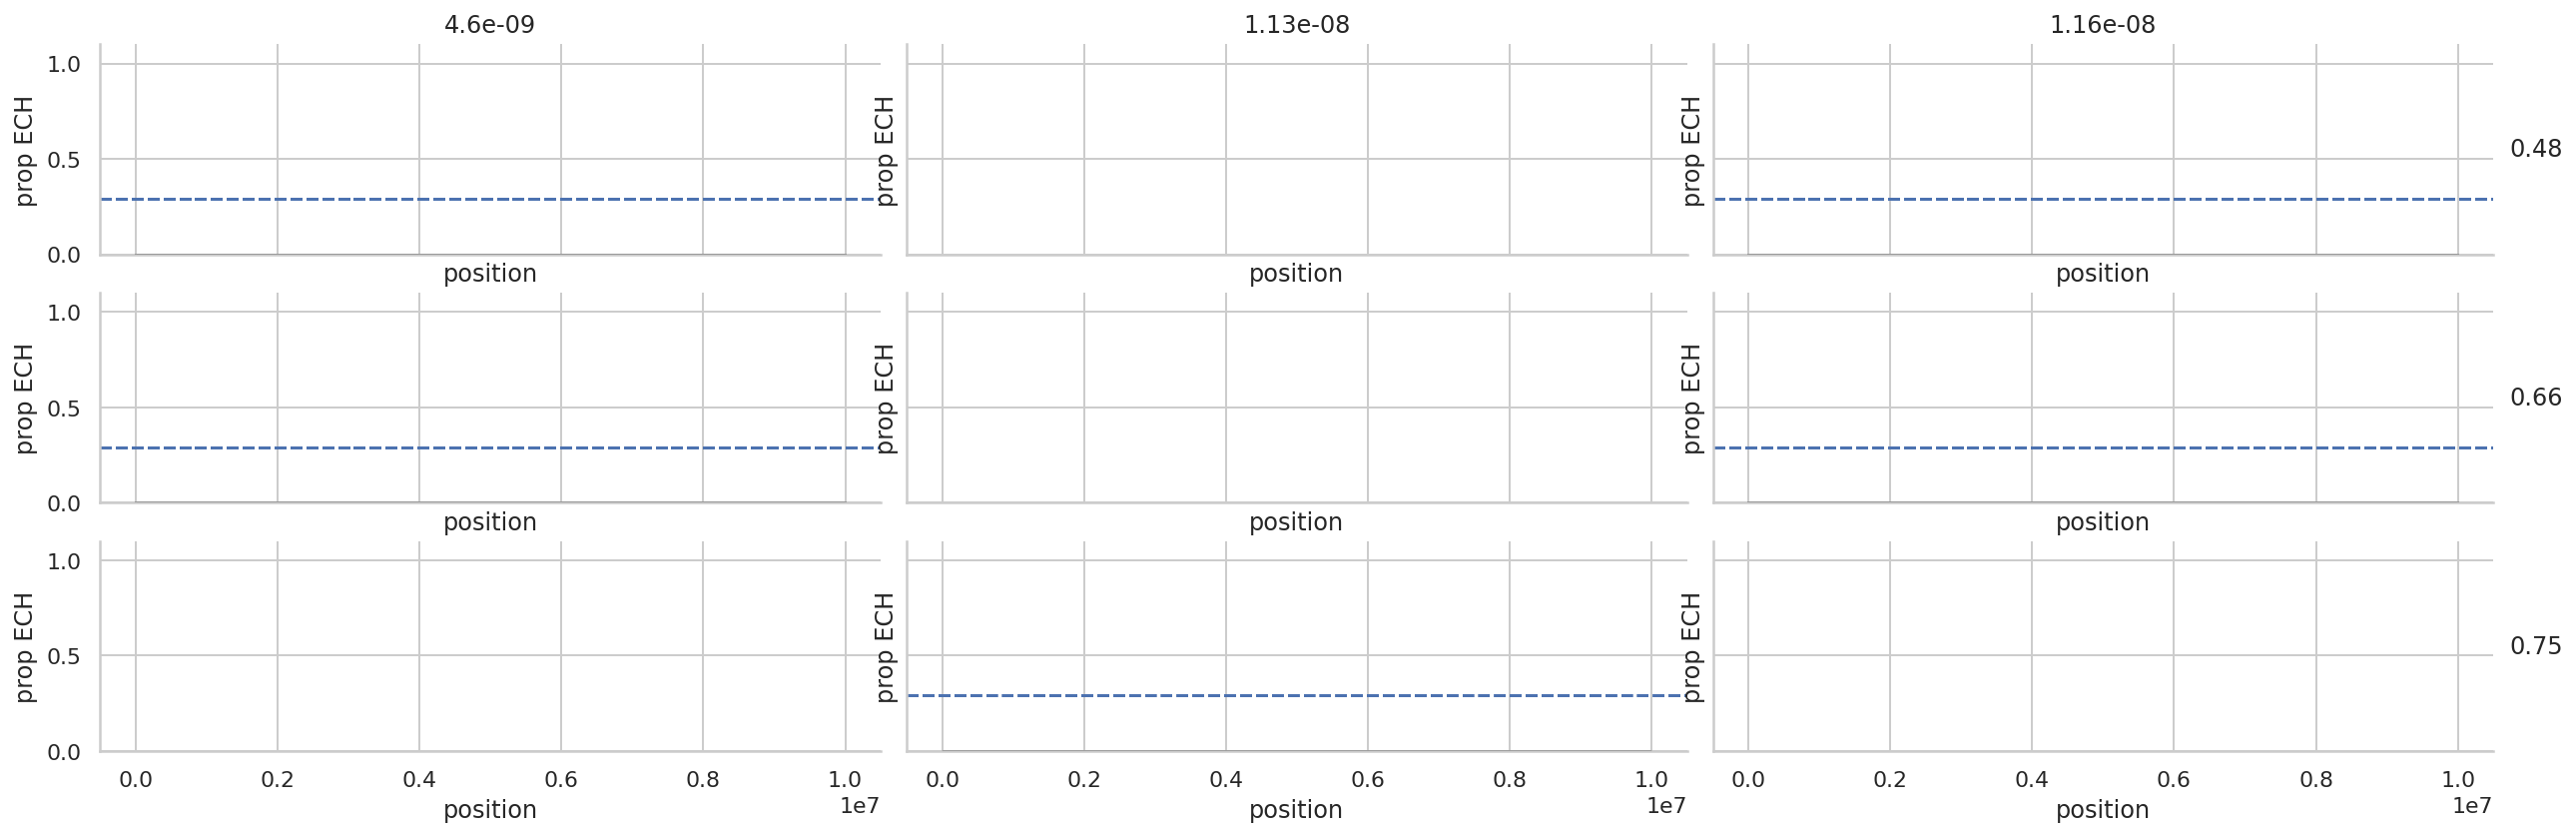

In [12]:
plot_df = prop_swept_data_auto.loc[(prop_swept_data_auto.sweep_type == 'nosweep') & \
                                   (prop_swept_data_auto.demography == 'standard')]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

## Load ECH summary for X

In [13]:
prop_swept_data = pd.read_hdf(str(ag.steps_dir / 'slim' / 'slim_summary.hdf')).loc[lambda df: df.chrom == 'X']
prop_swept_data['prop_swept'] = prop_swept_data.nr_swept / prop_swept_data.total
prop_swept_data['x_auto_ratio'] = prop_swept_data['size_reduction'] * 3 / 4
prop_swept_data.head()

,start,end,nr_swept,total,demography,chrom,size_reduction,rec_rate_per_gen,sweep_start,sweep_type,selcoef,replication,min_clade_percent,prop_swept,x_auto_ratio
0,0,100000,0,140,truncated,X,0.64,1.160000e-08,0,nosweep,0.0,82,29,0.0,0.48
1,100000,200000,0,140,truncated,X,0.64,1.160000e-08,0,nosweep,0.0,82,29,0.0,0.48
2,200000,300000,0,140,truncated,X,0.64,1.160000e-08,0,nosweep,0.0,82,29,0.0,0.48
3,300000,400000,0,140,truncated,X,0.64,1.160000e-08,0,nosweep,0.0,82,29,0.0,0.48
4,400000,500000,0,140,truncated,X,0.64,1.160000e-08,0,nosweep,0.0,82,29,0.0,0.48


## Neutral simulations

Standard demography:

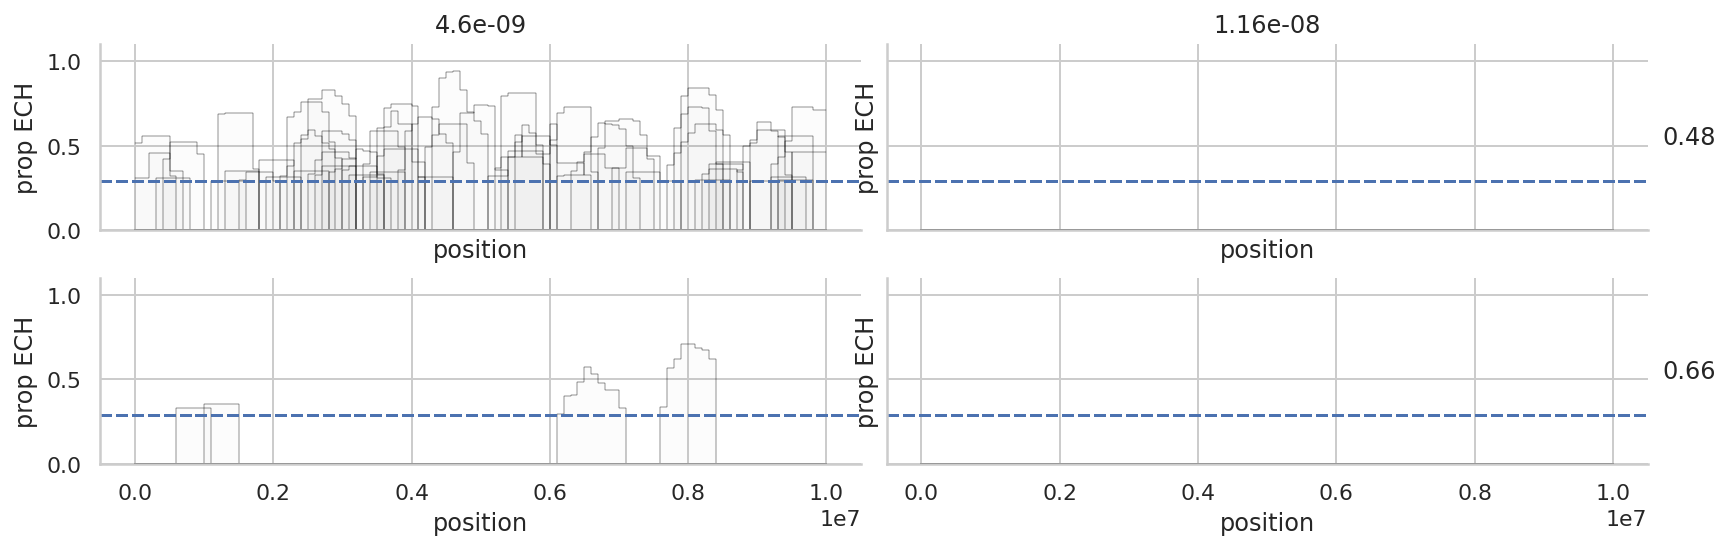

In [14]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'standard')]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

When we compute the probability of obtaining an ECH in the most conservative scenario, we need to take into account that this only applies to a small part of the X.

Truncated demography:

In [15]:
# plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
#                               (prop_swept_data.demography == 'truncated')]

# with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
#                       hue='replication', sharex=True, sharey=True, margin_titles=True,
#                      height=2, aspect=3)
#     g.map(facet_plot, 'start', 'end', 'prop_swept')

#     for ax in g.axes.flat:
#         plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
#     g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

#     for ax in g.axes.flat:
#         ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
#         ax.set_ylabel('prop ECH')        
#         plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

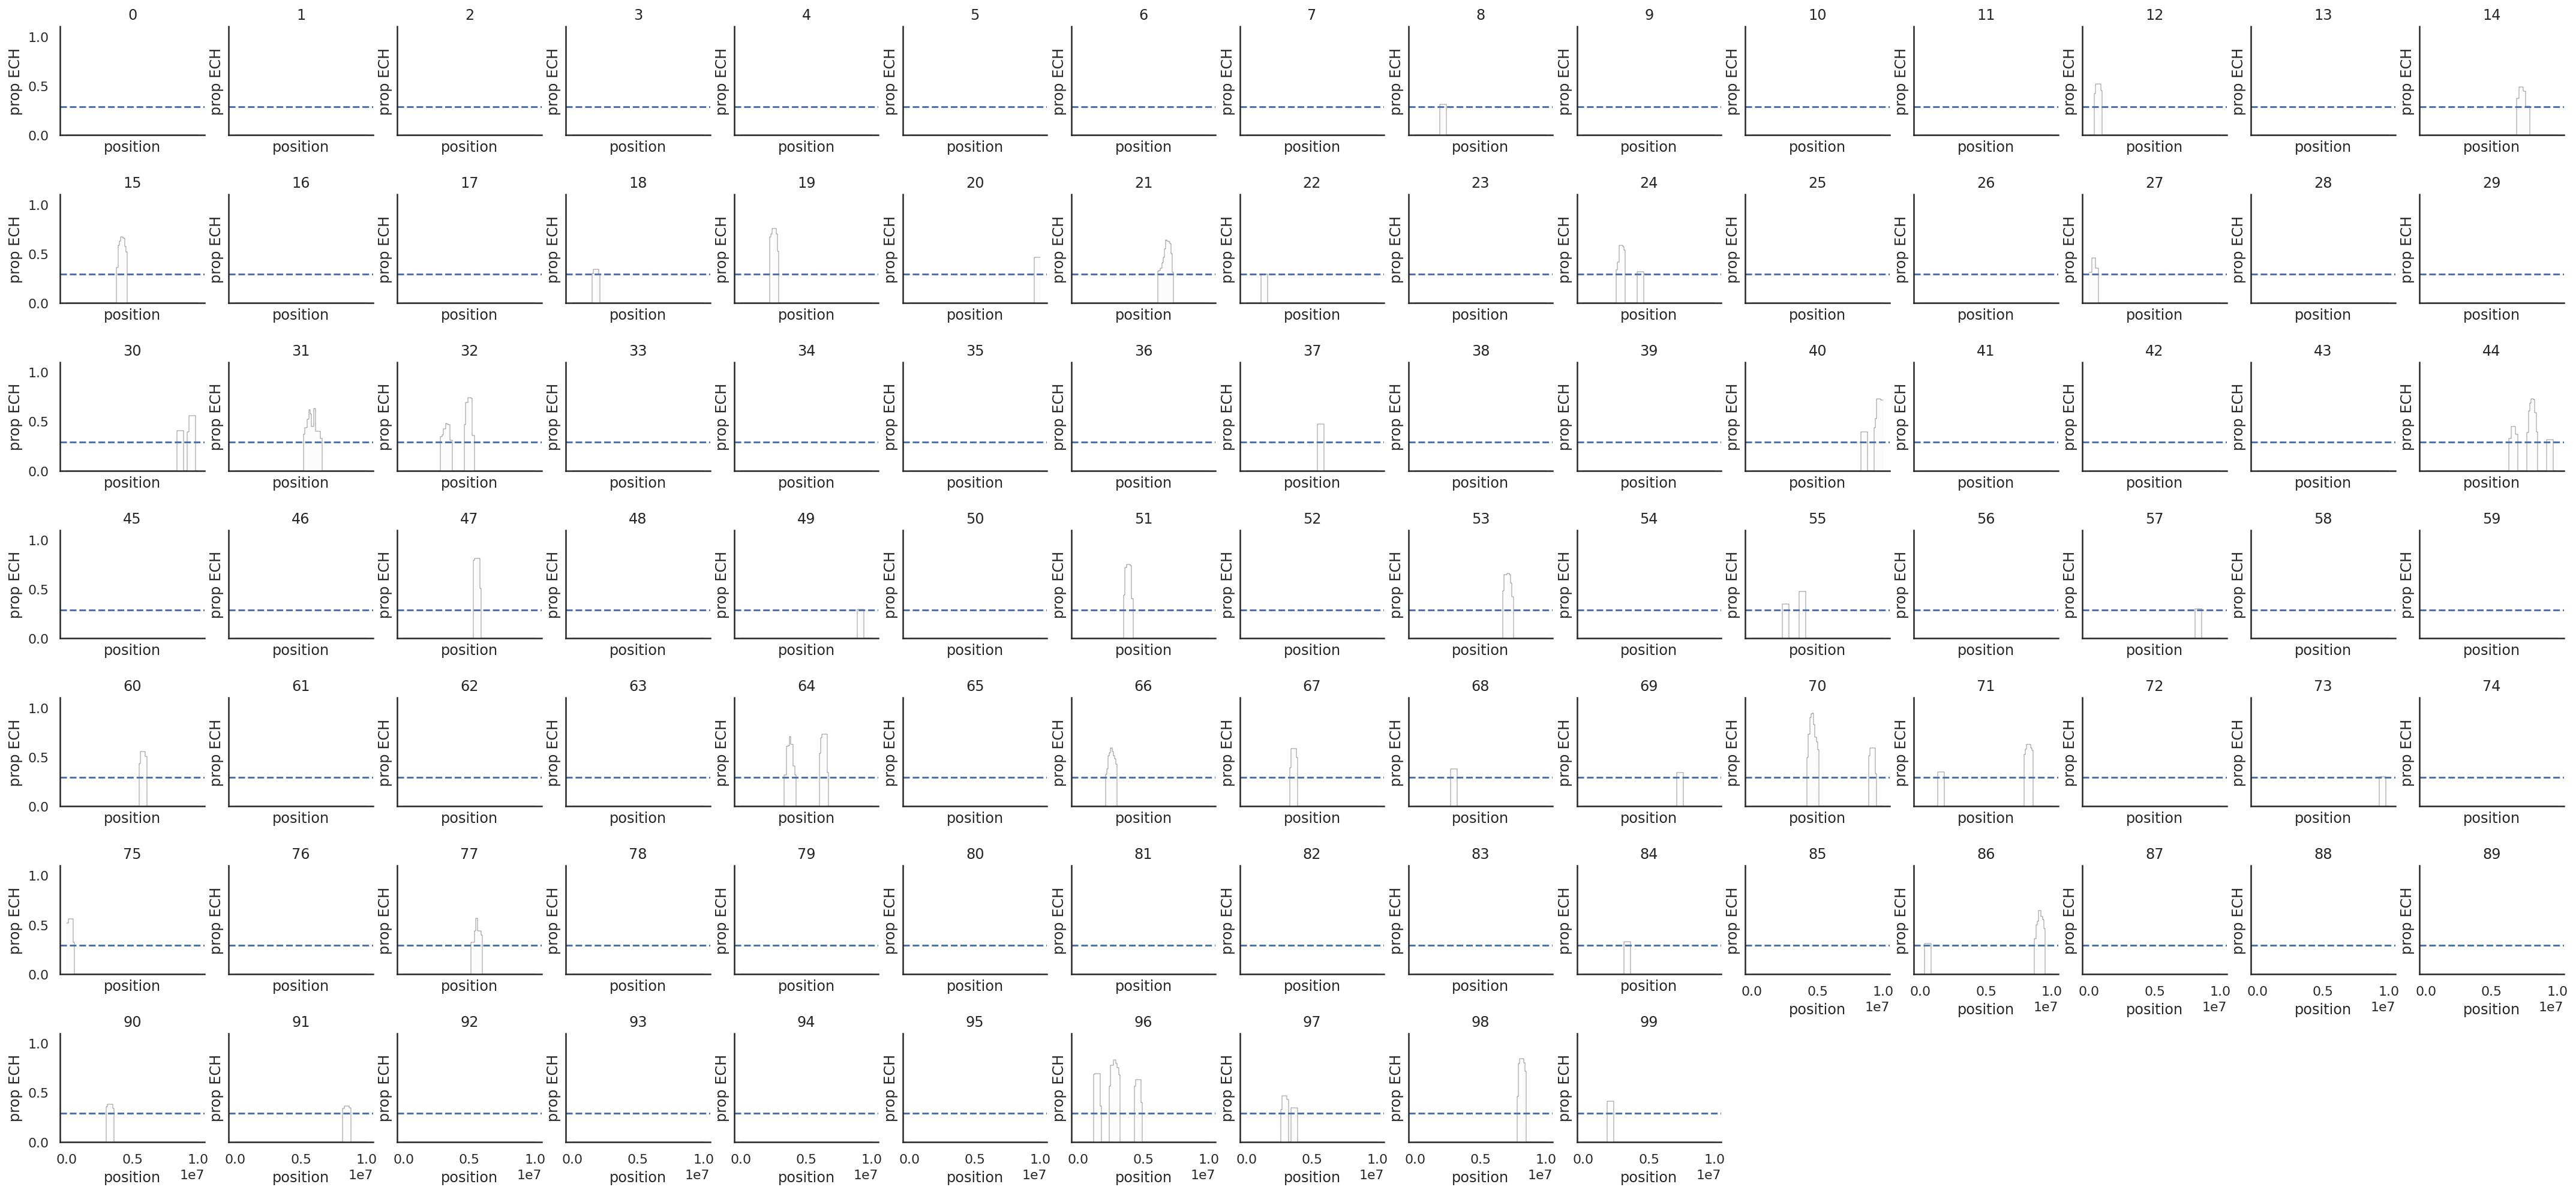

In [16]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.rec_rate_per_gen == 4.6e-9) & \
                              (prop_swept_data.x_auto_ratio == 0.48)] 

with sns.axes_style('white'):
    g = sns.FacetGrid(plot_df, col='replication', col_wrap=15,
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=1)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") 

In [17]:
# plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
#                               (prop_swept_data.demography == 'truncated') & \
#                               (prop_swept_data.rec_rate_per_gen == 4.6e-9) & \
#                               (prop_swept_data.x_auto_ratio == 0.48)] 

# with sns.axes_style('white'):
#     g = sns.FacetGrid(plot_df, col='replication', col_wrap=15,
#                       hue='replication', sharex=True, sharey=True, margin_titles=True,
#                      height=2, aspect=1)
#     g.map(facet_plot, 'start', 'end', 'prop_swept')

#     for ax in g.axes.flat:
#         plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
#     g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

#     for ax in g.axes.flat:
#         ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
#         ax.set_ylabel('prop ECH')        
#         plt.setp(ax.texts, rotation="0") 

Load 90% ECH regions

In [18]:
extended_peak_regions_90 = pd.read_hdf(ag.results_dir / f'extended_peak_regions_{ech_calling_tag}_90%.hdf')
extended_peak_regions_90['chrom'] = 'chrX'

### Plots to make for real data and simulations

- Proportion of ECH in each individual
- Number of peaks that each individual is part of (accounting for whole chrX vs. 10Mb)
- Length distribution of ECHs
- Proportion of individuals with ECH (where ECHs ca called)

### Distribution of ECH peak heights and proportion of ECH across simulations

In [19]:
subset_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'standard')]

Proportion of ECH across simulations:

In [20]:
subset_df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).prop_swept.mean()

rec_rate_per_gen  x_auto_ratio
4.600000e-09      0.48            0.018060
                  0.66            0.001267
1.160000e-08      0.48            0.000000
                  0.66            0.000000
Name: prop_swept, dtype: float64

Bootstrap batches of 15 simulations to reproduce ~150Mb X chromosome to get 95% percentile:

In [21]:
def bootstrap(df):
    return pd.Series([df.iloc[np.random.randint(len(df), size=15)].prop_swept.mean() for _ in range(10000)])

df = subset_df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).apply(bootstrap).reset_index()
df = df.melt(id_vars=['rec_rate_per_gen', 'x_auto_ratio'])

In [22]:
from scipy import stats


In [23]:
df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).value.agg(mean_prop_swept=np.mean, 
                                                           quantile_5=lambda sr: np.quantile(sr, q=0.05),
                                                           quantile_95=lambda sr: np.quantile(sr, q=0.95),
                                                           prob=lambda sr: 1-stats.percentileofscore(sr, 0.14)/100
                                                          )

mean_prop_swept  quantile_5  quantile_95  \
rec_rate_per_gen x_auto_ratio                                             
4.600000e-09     0.48                 0.018289         0.0     0.068095   
                 0.66                 0.001261         0.0     0.000000   
1.160000e-08     0.48                 0.000000         0.0     0.000000   
                 0.66                 0.000000         0.0     0.000000   

                                 prob  
rec_rate_per_gen x_auto_ratio          
4.600000e-09     0.48          0.0008  
                 0.66          0.0000  
1.160000e-08     0.48          0.0000  
                 0.66          0.0000

This is what compared to the 14% ECH in the actual data.

Distribution of peak prop_swept in simulations compared to our observations:

In [24]:
plot_df = subset_df.groupby(['rec_rate_per_gen', 'x_auto_ratio', 'replication']).prop_swept.max().reset_index().loc[lambda df: df.prop_swept > 0]
plot_df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).prop_swept.mean()

rec_rate_per_gen  x_auto_ratio
4.600000e-09      0.48            0.550510
                  0.66            0.489286
Name: prop_swept, dtype: float64

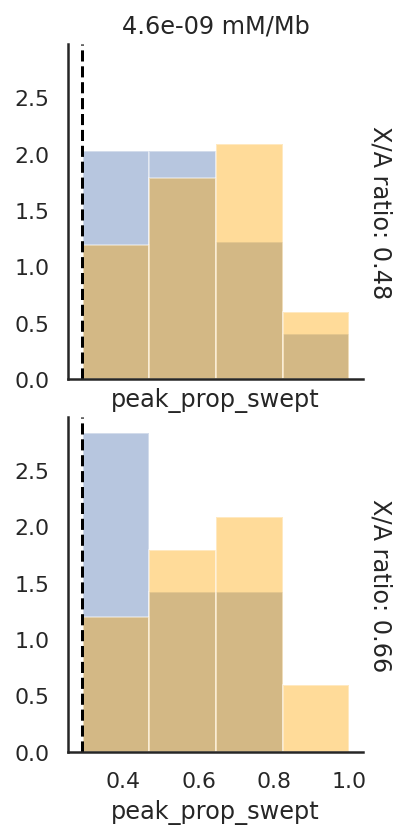

In [25]:
with sns.axes_style('white'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio',
                      sharex=True, sharey=True, margin_titles=True, legend_out=True,
                     # height=2, aspect=1
                     )
    bins = np.linspace(plot_df.prop_swept.min(), 1, 5)
#     bins = None
    norm_hist = True
    kde = False
    g.map(sns.distplot, 'prop_swept', kde=kde, norm_hist=norm_hist, bins=bins)
    
    for ax in g.axes.flat:
        sns.distplot(extended_peak_regions_90.peak_prop_swept, ax=ax, color='orange', kde=kde, norm_hist=norm_hist, bins=bins)
        ax.axvline(0.29, linestyle='dashed', color='black')
    
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = 'X/A ratio: {row_name}', col_template = '{col_name} mM/Mb')

In [26]:
subset_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'nosweep') & \
                              (prop_swept_data.demography == 'truncated')]

Proportion of ECH across simulations:

In [27]:
subset_df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).prop_swept.mean()

rec_rate_per_gen  x_auto_ratio
4.600000e-09      0.48            0.055467
                  0.66            0.005682
1.160000e-08      0.48            0.004986
                  0.66            0.000154
Name: prop_swept, dtype: float64

This is what compared to the 14% ECH in the actual data. Given that only a part of the chromosme is as extreme as our regions, the expected prop_swept is between 1% and 5%:

Distribution of peak prop_swept in simulations compared to our observations:

In [28]:
plot_df = subset_df.groupby(['rec_rate_per_gen', 'x_auto_ratio', 'replication']).prop_swept.max().reset_index().loc[lambda df: df.prop_swept > 0]
plot_df.groupby(['rec_rate_per_gen', 'x_auto_ratio']).prop_swept.mean()

rec_rate_per_gen  x_auto_ratio
4.600000e-09      0.48            0.458992
                  0.66            0.369048
1.160000e-08      0.48            0.374436
                  0.66            0.307143
Name: prop_swept, dtype: float64

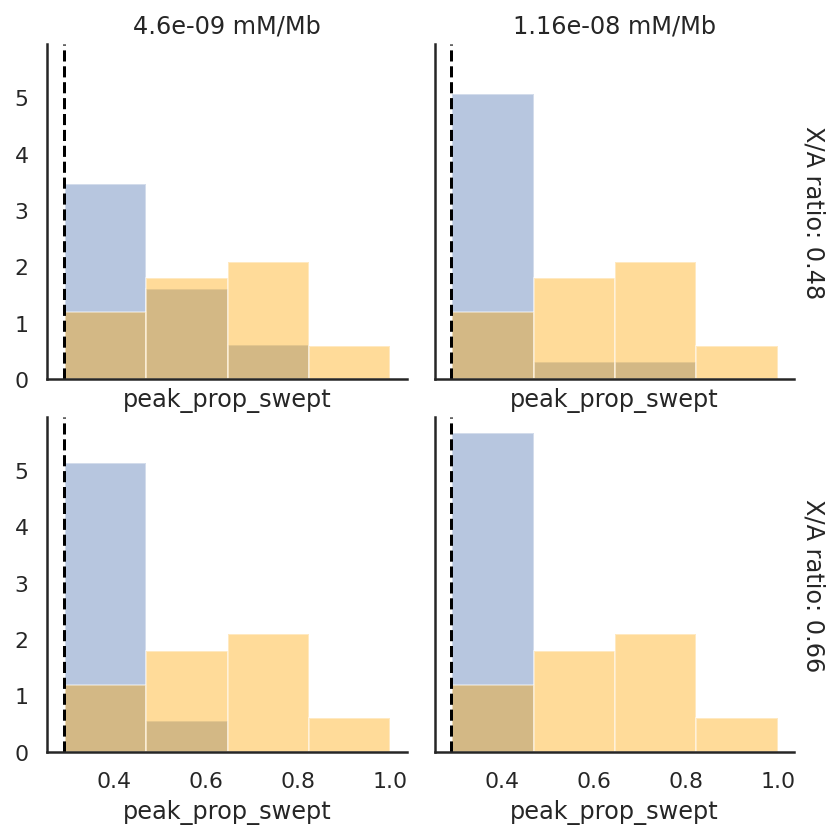

In [29]:
with sns.axes_style('white'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio',
                      sharex=True, sharey=True, margin_titles=True,
                     # height=2, aspect=1
                     )
    bins = np.linspace(plot_df.prop_swept.min(), 1, 5)
#     bins = None
    norm_hist = True
    kde = False
    g.map(sns.distplot, 'prop_swept', kde=kde, norm_hist=norm_hist, bins=bins)
    
    for ax in g.axes.flat:
        sns.distplot(extended_peak_regions_90.peak_prop_swept, ax=ax, color='orange', kde=kde, norm_hist=norm_hist, bins=bins)
        ax.axvline(0.29, linestyle='dashed', color='black')
    
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = 'X/A ratio: {row_name}', col_template = '{col_name} mM/Mb')

## Complete sweeps

s = 0.1

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'complete') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.selcoef == 0.1) ]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

s = 0.01

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'complete') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.selcoef == 0.01) ]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

## Partial sweeps

s = 0.1

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'partial') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.selcoef == 0.1) ]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

s = 0.01

In [ ]:
plot_df = prop_swept_data.loc[(prop_swept_data.sweep_type == 'partial') & \
                              (prop_swept_data.demography == 'standard') & \
                              (prop_swept_data.selcoef == 0.01) ]

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(plot_df, col='rec_rate_per_gen', row='x_auto_ratio', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=2, aspect=3)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        ax.set_xlabel('position') # need to set labels manually because the names of facet function are start and end.
        ax.set_ylabel('prop ECH')        
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles

-----

In [ ]:
with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(prop_swept_data, col='simulation', row='selection_coef', 
    g = sns.FacetGrid(prop_swept_data.loc[prop_swept_data.simulation.str.startswith('standard_40_4650')],
                      col='selection_coef', row='simulation', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     height=3, aspect=5)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles



In [ ]:
prop_swept_data.simulation.unique()

In [ ]:
def facet_plot(start, end, prop_swept, **kwargs):
    x = [j for i in zip(start, end) for j in i]
    y = [j for i in zip(prop_swept, prop_swept) for j in i]      
    plt.plot(x, y, color='black', linewidth=0.2)
#    plt.plot(x, y, linewidth=0.2, **kwargs)
    plt.ylim((0, 1))
    plt.fill_between(x, 0, y, color='gray', alpha=0.5)

with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(prop_swept_data, col='simulation', row='selection_coef', 
    g = sns.FacetGrid(prop_swept_data.loc[prop_swept_data.simulation.isin(['standard_55_4650_X_nosweep_98275',
                                                                          'standard_40_4650_X_nosweep_98275',
                                                                          'standard_48_4650_X_nosweep_98275',
                                                                          'standard_66_4650_X_nosweep_98275'])],
                      col='replication', row='simulation', sharex=True, sharey=True, margin_titles=True,
                     height=4, aspect=0.5)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles



## TMRCA computations

In [ ]:
# from math import exp

# def lamb(i):
#     # lamb(i) rate of coalescence from i-1 to i
#     i += 1
#     return i*(i-1)/2

# samples = 5 # total samples
# setsize = 3 # size of clade (we want to see at least one such clade coalesce before time t)
# t = 1

# for n in range(setsize, samples+1):
#     # loop from setsize to samples (3 to 5):
#     p = 0
#     for i in range(1, n):
#         # loop from 1 to n-1:
#         p += np.prod([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n) if i != j]) \
#         * exp(-lamb(n)*t) \
#         * (lamb(i)/(lamb(i)-lamb(n))) \
#         * (-exp(-(lamb(i)-lamb(n))*t) + 1)
#     # combinatorial expression:
#     p *= scipy.misc.comb(n, setsize) / scipy.misc.comb(samples, setsize)
# p
    


In [ ]:
# def lamb(x):
#     x += 1
#     return x*(x-1)/2


# N = 3000
# n = 42
# t = 1

# prob = 0
# for i in range(1, n):
#     prob += (1 - math.exp(-lamb(i)*t)) * np.prod([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n) if i != j])
# prob * scipy.misc.comb(140, 42)

In [ ]:
#scipy.misc.comb(140, 42)

In [ ]:
#1- math.exp(-lamb(1))

In [ ]:
# def lamb(x):
#     return x*(x-1)/2

# t = 10
# n = 20

# prob = 0
# for i in range(1, n+1):
# #     print([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n+1) if i != j])
#     prob += lamb(i) * math.exp(-lamb(i)*t) * np.prod([lamb(j)/(lamb(j)-lamb(i)) for j in range(1, n+1) if i != j])
# prob #* scipy.misc.comb(n, i)

In [ ]:
#lamb(3)

In [ ]:
# import scipy

# def coal_n_to_l(n, l, t):
#     """Prob of reducing n lineages to l in time t"""
#     Q = np.zeros(shape=(n-l+1, n-l+1))
#     for x in range(n-l):
#         rate = scipy.misc.comb(n-x, 2) / (2 * pop_size)
#         Q[x][x] = -rate
#         Q[x][x+1] = rate
#     return scipy.linalg.expm(Q*t)[0][-1]

# def clade_prob(n, l, t, i):
#     """Prob of one among l lineages being ancestor to i among n"""
# #     if i == 1 or l == 1:
# #         return 1
# #     else:
#     return scipy.misc.comb(n-i-1, l-2) / scipy.misc.comb(n-1, l-1)
        
# n = 5
# t = 36
# pop_size = 300
# i = 2

# total_prop = 0
# for l in range(1, n):
#     total_prop += coal_n_to_l(n, l, t) * clade_prob(n, l, t, i)
# total_prop

In [ ]:
# n = 5
# t = 360
# pop_size = 30

# i = 2

# #l = 3

# total_prop = 0

# for l in [3]:#range(1, n):
    
#     # probability of having l out of n left at time t
#     Q = np.zeros(shape=(n-l+1, n-l+1))
#     for x in range(n-l):
#         rate = scipy.misc.comb(n-x, 2) / (2 * pop_size)
#         Q[x][x] = -rate
#         Q[x][x+1] = rate
#     prop_coalescences_n_to_l = scipy.linalg.expm(Q*t)[0][-1]
#     prop_coalescences_n_to_l

    
#     if i == 1 or l == 1:
#         prop_ancestor_to_i = 1 # CHECK THAT THIS IS OK
#     else:
#         prop_ancestor_to_i = scipy.misc.comb(n-i-1, l-2) / scipy.misc.comb(n-1, l-1)

#     assert prop_ancestor_to_i <= 1, prop_ancestor_to_i

#     prob = prop_coalescences_n_to_l * prop_ancestor_to_i

#     print(prop_coalescences_n_to_l, prop_ancestor_to_i)

#     total_prop += prob
# total_prop